In [74]:
import torch
import torch.nn.functional as F
def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        steps = torch.linspace(0, 1, spec['num_timesteps'] + 1, dtype=torch.float64)
        alpha_bar = torch.square(torch.cos(((steps + 0.008) / 1.008) * torch.pi / 2))
        betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999))
        return betas.to(device)
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])
    
    
def _get_gaussian_transition_mat(t):
    r"""Computes transition matrix for q(x_t|x_{t-1}).

    This method constructs a transition matrix Q with
    decaying entries as a function of how far off diagonal the entry is.
    Normalization option 1:
    Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                1 - \sum_{l \neq i} Q_{il}  if i==j.
                0                          else.

    Normalization option 2:
    tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                        0                        else.

    Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

    Args:
        t: timestep. integer scalar (or numpy array?)

    Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
    """
    num_classes = 2
    device = 'cpu'
    transition_bands = 1
    spec = {'type': 'cosine', 'start': 0.9, 'stop': 1.0, 'num_timesteps': 100}
    betas = get_diffusion_betas(spec, device=device)
    transition_bands = transition_bands if transition_bands else num_classes - 1

    beta_t = betas[t]

    mat = torch.zeros((num_classes, num_classes),
                    dtype=torch.float64).to(device, non_blocking=True)

    # Make the values correspond to a similar type of gaussian as in the
    # gaussian diffusion case for continuous state spaces.
    values = torch.linspace(torch.tensor(0.), torch.tensor(num_classes-1), num_classes, dtype=torch.float64).to(device, non_blocking=True)
    #print(values)   # [0, 1]
    values = values * 2./ (num_classes - 1.)
    #print(values)   # [0, 2]
    values = values[:transition_bands+1]
    #print(values)   # [0, 2]
    values = -values * values / beta_t
    #print(values)   # [0, -6300]
    
    # To reverse the tensor 'values' starting from the second element
    reversed_values = values[1:].flip(dims=[0])
    #print(reversed_values)  # [-6300]
    # Concatenating the reversed values with the original values
    values = torch.cat([reversed_values, values], dim=0)
    #print(values)   # [-6300, 0, -6300]
    values = F.softmax(values, dim=0)
    #print(values)   # [0, 1, 0]
    values = values[transition_bands:]
    #print(values)   # [1, 0]
    
    for k in range(1, transition_bands + 1):
        off_diag = torch.full((num_classes - k,), values[k], dtype=torch.float64).to(device, non_blocking=True)

        mat += torch.diag(off_diag, k)
        mat += torch.diag(off_diag, -k)

    # Add diagonal values such that rows and columns sum to one.
    # Technically only the ROWS need to sum to one
    # NOTE: this normalization leads to a doubly stochastic matrix,
    # which is necessary if we want to have a uniform stationary distribution.
    diag = 1. - mat.sum(dim=1)
    mat += torch.diag_embed(diag)

    return mat.to(device, non_blocking=True)

def _get_prior_distribution_transition_mat(t):
        """Computes transition matrix for q(x_t|x_{t-1}).
        Use cosine schedule for these transition matrices.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        device = 'cpu'
        spec = {'type': 'cosine', 'start': 0.9, 'stop': 1.0, 'num_timesteps': 100}
        betas = get_diffusion_betas(spec, device=device)
        beta_t = betas[t]
        num_classes = 2
        class_probs = torch.tensor([1 - 10/15000, 10/15000], device=device)
        mat = torch.zeros((num_classes, num_classes), dtype=torch.float64).to(device, non_blocking=True)

        '''for i in range(num_classes):
            for j in range(num_classes):
                if i != j:
                    mat[i, j] = beta_t * class_probs[j]
                else:
                    mat[i, j] = 1 - beta_t + beta_t * class_probs[j]'''
        mat = beta_t * class_probs + (1 - beta_t) * torch.eye(2, device=device)
        
        return mat


q_one_step_mats = [_get_prior_distribution_transition_mat(t)
                            for t in range(0, 100)]
q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to('cpu', non_blocking=True)
assert q_onestep_mats.shape == (100,
                                    2,
                                    2)

# Construct transition matrices for q(x_t|x_start)
q_mat_t = q_onestep_mats[0]
q_mats = [q_mat_t]
for t in range(1, 100):
    # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
    q_mat_t = torch.tensordot(q_mat_t, q_onestep_mats[t],
                            dims=[[1], [0]])
    q_mats.append(q_mat_t)
q_mats = torch.stack(q_mats, axis=0)

for t in range(0, 100, 9):
    print(q_mats[t])
    # print(_get_gaussian_transition_mat(t))
    # print(_get_prior_distribution_transition_mat(t))

'''import matplotlib.pyplot as plt

spec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}
betas = get_diffusion_betas(spec, device='cpu')
plt.plot(betas)
plt.show()'''

tensor([[1.0000e+00, 4.2085e-07],
        [6.3086e-04, 9.9937e-01]])
tensor([[9.9998e-01, 1.8605e-05],
        [2.7889e-02, 9.7211e-01]])
tensor([[9.9994e-01, 6.1386e-05],
        [9.2017e-02, 9.0798e-01]])
tensor([[9.9987e-01, 1.2542e-04],
        [1.8800e-01, 8.1200e-01]])
tensor([[9.9979e-01, 2.0570e-04],
        [3.0835e-01, 6.9165e-01]])
tensor([[9.9970e-01, 2.9595e-04],
        [4.4364e-01, 5.5636e-01]])
tensor([[9.9961e-01, 3.8913e-04],
        [5.8330e-01, 4.1670e-01]])
tensor([[9.9952e-01, 4.7793e-04],
        [7.1642e-01, 2.8358e-01]])
tensor([[9.9944e-01, 5.5543e-04],
        [8.3259e-01, 1.6741e-01]])
tensor([[9.9938e-01, 6.1557e-04],
        [9.2273e-01, 7.7265e-02]])
tensor([[9.9935e-01, 6.5364e-04],
        [9.7980e-01, 2.0198e-02]])
tensor([[9.9933e-01, 6.6667e-04],
        [9.9933e-01, 6.6691e-04]])


"import matplotlib.pyplot as plt\n\nspec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}\nbetas = get_diffusion_betas(spec, device='cpu')\nplt.plot(betas)\nplt.show()"

In [17]:
e_marginals = torch.tensor([0.9, 0.1], dtype=torch.float64)
print(e_marginals.unsqueeze(0).expand(2, -1).unsqueeze(0))

tensor([[[0.9000, 0.1000],
         [0.9000, 0.1000]]], dtype=torch.float64)


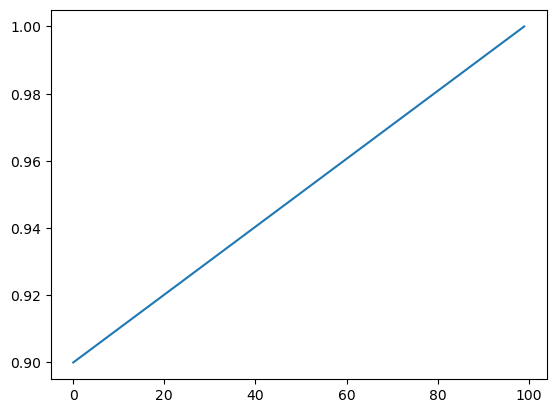

[0. 1.]
[0. 2.]
[0. 2.]
[-0. -4.]
[-4. -0. -4.]
[0.01766842 0.96466316 0.01766842]
[0.96466316 0.01766842]


array([[0.98233158, 0.01766842],
       [0.01766842, 0.98233158]])

In [65]:
import numpy as onp
def get_diffusion_betas(spec):
  """Get betas from the hyperparameters."""
  if spec['type'] == 'linear':
    # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
    # To be used with Gaussian diffusion models in continuous and discrete
    # state spaces.
    # To be used with transition_mat_type = 'gaussian'
    return onp.linspace(spec['start'], spec['stop'], spec['num_timesteps'])
  elif spec['type'] == 'cosine':
    # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
    # To be used with transition_mat_type = 'uniform'.
    steps = (
        onp.arange(spec['num_timesteps'] + 1, dtype=onp.float64) /
        spec['num_timesteps'])
    alpha_bar = onp.cos((steps + 0.008) / 1.008 * onp.pi / 2)
    betas = onp.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], 0.999)
    return betas
  elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
    # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
    # To be used with absorbing state models.
    # ensures that the probability of decaying to the absorbing state
    # increases linearly over time, and is 1 for t = T-1 (the final time).
    # To be used with transition_mat_type = 'absorbing'
    return 1. / onp.linspace(spec['num_timesteps'], 1., spec['num_timesteps'])
  else:
    raise NotImplementedError(spec['type'])
  
spec = {'type': 'linear', 'start': 0.9, 'stop': 1.0, 'num_timesteps': 100}
betas = get_diffusion_betas(spec)
plt.plot(betas)
plt.show()

import scipy
def _get_gaussian_transition_mat(t):
    r"""Computes transition matrix for q(x_t|x_{t-1}).

    This method constructs a transition matrix Q with
    decaying entries as a function of how far off diagonal the entry is.
    Normalization option 1:
    Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
             1 - \sum_{l \neq i} Q_{il}  if i==j.
             0                          else.

    Normalization option 2:
    tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                     0                        else.

    Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

    Args:
      t: timestep. integer scalar (or numpy array?)

    Returns:
      Q_t: transition matrix. shape = (num_pixel_vals, num_pixel_vals).
    """
    transition_bands = 2 - 1
    betas = get_diffusion_betas(spec)
    beta_t = betas[t]

    mat = onp.zeros((2, 2),
                    dtype=onp.float64)

    # Make the values correspond to a similar type of gaussian as in the
    # gaussian diffusion case for continuous state spaces.
    values = onp.linspace(start=0., stop=1., num=2,
                          endpoint=True, dtype=onp.float64)
    print(values)
    values = values * 2./ (2 - 1.)
    print(values)
    values = values[:transition_bands+1]
    print(values)
    values = -values * values / beta_t
    print(values)

    values = onp.concatenate([values[:0:-1], values], axis=0)
    print(values)
    values = scipy.special.softmax(values, axis=0)
    print(values)
    values = values[transition_bands:]
    print(values)
    for k in range(1, transition_bands + 1):
      off_diag = onp.full(shape=(2 - k,),
                          fill_value=values[k],
                          dtype=onp.float64)

      mat += onp.diag(off_diag, k=k)
      mat += onp.diag(off_diag, k=-k)

    # Add diagonal values such that rows and columns sum to one.
    # Technically only the ROWS need to sum to one
    # NOTE: this normalization leads to a doubly stochastic matrix,
    # which is necessary if we want to have a uniform stationary distribution.
    diag = 1. - mat.sum(1)
    mat += onp.diag(diag, k=0)

    return mat
  
_get_gaussian_transition_mat(99)

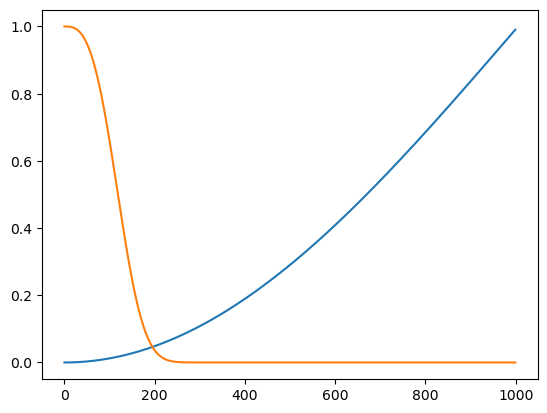

In [48]:
import numpy as np

def cosine_beta_schedule(T, s=0.008):
    """
    Generate a cosine schedule for diffusion betas.
    
    Args:
    - T (int): The total number of diffusion timesteps.
    - s (float): A small constant to ensure the betas do not reach 0, which could cause numerical stability issues.
    
    Returns:
    - np.array: An array of length T with the beta values for each timestep.
    """
    steps = np.arange(T, dtype=np.float64)
    x = s + (1 - s) * np.cos(0.5 * np.pi * steps / T)
    betas = 1 - x / x.max()
    return betas

# Example usage
T = 1000  # Total number of diffusion steps
betas = cosine_beta_schedule(T)
alphas = 1 - betas
alpha_bar = np.cumprod(alphas)
plt.plot(betas)
#plt.plot(alphas)
plt.plot(alpha_bar)
plt.show()

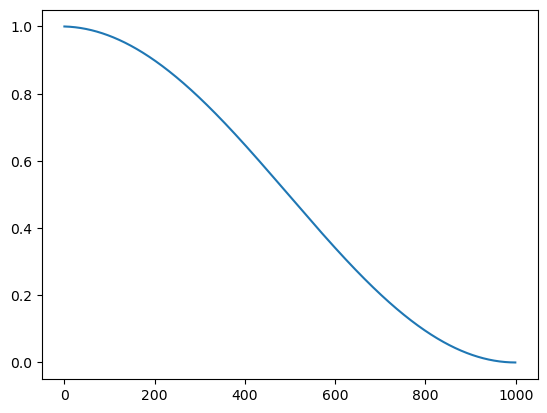

In [50]:
import numpy as np

def cosine_alpha_bar_schedule(T, t, s=0.008):
    """
    Generate a cosine schedule for diffusion betas.
    
    Args:
    - T (int): The total number of diffusion timesteps.
    - s (float): A small constant to ensure the betas do not reach 0, which could cause numerical stability issues.
    
    Returns:
    - np.array: An array of length T with the beta values for each timestep.
    """
    def f_t(t):
        return np.square(np.cos(((t/T + s) * np.pi / 2) / (1 + s)))
    f_0 = f_t(0)
    return f_t(t) / f_0

alpha_bar = [cosine_alpha_bar_schedule(1000, t) for t in range(1000)]
plt.plot(alpha_bar)
plt.show()

In [29]:
# coding=utf-8
# Copyright 2024 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Diffusion for discrete state spaces."""

import torch
import time
import torch.nn as nn
import torch.nn.functional as F


def make_diffusion(diffusion_config, model_config, num_edges, future_len, device):
    """HParams -> diffusion object."""
    return CategoricalDiffusion(
        betas=get_diffusion_betas(diffusion_config, device),
        model_prediction=model_config['model_prediction'],
        model_output=model_config['model_output'],
        transition_mat_type=model_config['transition_mat_type'],
        transition_bands=model_config['transition_bands'],
        loss_type=model_config['loss_type'],
        hybrid_coeff=model_config['hybrid_coeff'],
        num_edges=num_edges,
        model_name=model_config['name'],
        future_len=future_len,
        device=device
)


def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        steps = torch.linspace(0, 1, spec['num_timesteps'] + 1, dtype=torch.float64)
        alpha_bar = torch.square(torch.cos(((steps + 0.008) / 1.008) * torch.pi / 2))
        betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999))
        return betas.to(device)
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])


class CategoricalDiffusion:
    """Discrete state space diffusion process.

    Time convention: noisy data is labeled x_0, ..., x_{T-1}, and original data
    is labeled x_start (or x_{-1}). This convention differs from the papers,
    which use x_1, ..., x_T for noisy data and x_0 for original data.
    """

    def __init__(self, *, betas, model_prediction, model_output,
               transition_mat_type, transition_bands, loss_type, hybrid_coeff,
               num_edges, torch_dtype=torch.float32, model_name=None, future_len=None, device=None):

        self.model_prediction = model_prediction  # *x_start*, xprev
        self.model_output = model_output  # logits or *logistic_pars*
        self.loss_type = loss_type  # kl, *hybrid*, cross_entropy_x_start
        self.hybrid_coeff = hybrid_coeff
        self.torch_dtype = torch_dtype
        self.model_name = model_name
        self.device = device

        # Data \in {0, ..., num_edges-1}
        self.num_classes = 2 # 0 or 1
        self.num_edges = num_edges
        self.future_len = future_len
        # self.class_weights = torch.tensor([self.future_len / self.num_edges, 1 - self.future_len / self.num_edges], dtype=torch.float64)
        self.class_weights = torch.tensor([0.4, 0.6], dtype=torch.float64)
        self.class_probs = torch.tensor([1 - self.future_len / self.num_edges, self.future_len / self.num_edges], dtype=torch.float64)
        self.transition_bands = transition_bands
        self.transition_mat_type = transition_mat_type
        self.eps = 1.e-6

        if not isinstance(betas, torch.Tensor):
            raise ValueError('expected betas to be a torch tensor')
        if not ((betas > 0).all() and (betas <= 1).all()):
            raise ValueError('betas must be in (0, 1]')

        # Computations here in float64 for accuracy
        self.betas = betas.to(dtype=torch.float64).to(self.device, non_blocking=True)
        self.num_timesteps, = betas.shape

        # Construct transition matrices for q(x_t|x_{t-1})
        # NOTE: t goes from {0, ..., T-1}
        if self.transition_mat_type == 'uniform':
            q_one_step_mats = [self._get_transition_mat(t) 
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'gaussian':
            q_one_step_mats = [self._get_gaussian_transition_mat(t)
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'absorbing':
            q_one_step_mats = [self._get_absorbing_transition_mat(t)
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'marginal_prior':
            q_one_step_mats = [self._get_prior_distribution_transition_mat(t)
                               for t in range(0, self.num_timesteps)]
        else:
            raise ValueError(
                f"transition_mat_type must be 'gaussian', 'uniform', 'absorbing', 'marginal_prior'"
                f", but is {self.transition_mat_type}"
                )

        self.q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to(self.device, non_blocking=True)
        assert self.q_onestep_mats.shape == (self.num_timesteps,
                                            self.num_classes,
                                            self.num_classes)

        # Construct transition matrices for q(x_t|x_start)
        q_mat_t = self.q_onestep_mats[0]
        q_mats = [q_mat_t]
        for t in range(1, self.num_timesteps):
            # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
            q_mat_t = torch.tensordot(q_mat_t, self.q_onestep_mats[t],
                                    dims=[[1], [0]])
            q_mats.append(q_mat_t)
        self.q_mats = torch.stack(q_mats, axis=0)
        assert self.q_mats.shape == (self.num_timesteps, self.num_classes,
                                    self.num_classes), self.q_mats.shape
        
        for t in range(0, self.num_timesteps, 9):
            print(self.q_mats[t])

        # Don't precompute transition matrices for q(x_{t-1} | x_t, x_start)
        # Can be computed from self.q_mats and self.q_one_step_mats.
        # Only need transpose of q_onestep_mats for posterior computation.
        self.transpose_q_onestep_mats = torch.transpose(self.q_onestep_mats, dim0=1, dim1=2)
        del self.q_onestep_mats

    def _get_full_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).

        Contrary to the band diagonal version, this method constructs a transition
        matrix with uniform probability to all other states.

        Args:
            t: timestep. integer scalar.

        Returns:
            Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]
        # Create a matrix filled with beta_t/num_classes
        mat = torch.full((self.num_classes, self.num_classes), 
                            fill_value=beta_t / float(self.num_classes),
                            dtype=torch.float64)

        # Create a diagonal matrix with values to be set on the diagonal of mat
        diag_val = 1. - beta_t * (self.num_classes - 1.) / self.num_classes
        diag_matrix = torch.diag(torch.full((self.num_classes,), diag_val, dtype=torch.float64))

        # Set the diagonal values
        mat.fill_diagonal_(diag_val)

        return mat

    def _get_transition_mat(self, t):
        r"""Computes transition matrix for q(x_t|x_{t-1}).

        This method constructs a transition
        matrix Q with
        Q_{ij} = beta_t / num_classes       if |i-j| <= self.transition_bands
                1 - \sum_{l \neq i} Q_{il} if i==j.
                0                          else.

        Args:
        t: timestep. integer scalar (or numpy array?)

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        if self.transition_bands is None:
            return self._get_full_transition_mat(t)
        # Assumes num_off_diags < num_classes
        beta_t = self.betas[t]
        
        mat = torch.zeros((self.num_classes, self.num_classes),
                        dtype=torch.float64)
        off_diag = torch.full((self.num_classes - 1,), fill_value=beta_t / float(self.num_classes), dtype=torch.float64)

        for k in range(1, self.transition_bands + 1):
            mat += torch.diag(off_diag, k)
            mat += torch.diag(off_diag, -k)
            off_diag = off_diag[:-1]

        # Add diagonal values such that rows sum to one
        diag = 1. - mat.sum(dim=1)
        mat += torch.diag(diag)
        
        return mat

    def _get_gaussian_transition_mat(self, t):
        r"""Computes transition matrix for q(x_t|x_{t-1}).

        This method constructs a transition matrix Q with
        decaying entries as a function of how far off diagonal the entry is.
        Normalization option 1:
        Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= self.transition_bands
                    1 - \sum_{l \neq i} Q_{il}  if i==j.
                    0                          else.

        Normalization option 2:
        tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= self.transition_bands
                            0                        else.

        Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

        Args:
            t: timestep. integer scalar (or numpy array?)

        Returns:
            Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        transition_bands = self.transition_bands if self.transition_bands else self.num_classes - 1

        beta_t = self.betas[t]

        mat = torch.zeros((self.num_classes, self.num_classes),
                        dtype=torch.float64).to(self.device, non_blocking=True)

        # Make the values correspond to a similar type of gaussian as in the
        # gaussian diffusion case for continuous state spaces.
        values = torch.linspace(torch.tensor(0.), torch.tensor(self.num_classes-1), self.num_classes, dtype=torch.float64).to(self.device, non_blocking=True)
        values = values * 2./ (self.num_classes - 1.)
        values = values[:transition_bands+1]
        values = -values * values / beta_t
        
        # To reverse the tensor 'values' starting from the second element
        reversed_values = values[1:].flip(dims=[0])
        # Concatenating the reversed values with the original values
        values = torch.cat([reversed_values, values], dim=0)
        values = F.softmax(values, dim=0)
        values = values[transition_bands:]
        
        for k in range(1, transition_bands + 1):
            off_diag = torch.full((self.num_classes - k,), values[k], dtype=torch.float64).to(self.device, non_blocking=True)

            mat += torch.diag(off_diag, k)
            mat += torch.diag(off_diag, -k)

        # Add diagonal values such that rows and columns sum to one.
        # Technically only the ROWS need to sum to one
        # NOTE: this normalization leads to a doubly stochastic matrix,
        # which is necessary if we want to have a uniform stationary distribution.
        diag = 1. - mat.sum(dim=1)
        mat += torch.diag_embed(diag)

        return mat.to(self.device, non_blocking=True)

    def _get_absorbing_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).

        Has an absorbing state for pixelvalues self.num_classes//2.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]

        diag = torch.full((self.num_classes,), 1. - beta_t, dtype=torch.float64).to(self.device, non_blocking=True)
        mat = torch.diag(diag)

        # Add beta_t to the num_classes/2-th column for the absorbing state
        mat[:, self.num_classes // 2] += beta_t

        return mat
    
    def _get_prior_distribution_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).
        Use cosine schedule for these transition matrices.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]
        mat = torch.zeros((self.num_classes, self.num_classes), dtype=torch.float64).to(self.device, non_blocking=True)

        '''for i in range(self.num_classes):
            for j in range(self.num_classes):
                if i != j:
                    mat[i, j] = beta_t * self.class_probs[j]
                else:
                    mat[i, j] = 1 - beta_t + beta_t * self.class_probs[j]'''

        mat = beta_t * self.class_probs + (1 - beta_t) * torch.eye(2, device=self.device)
        
        return mat
    
    def _get_custom_transition_mat(self, t):
        # TODO: return a matrix [[1 - a_t a_t], [a_t, 1 - a_t]], with a_t = t/T
        pass

    def _at(self, a, t, x):
        """
        Extract coefficients at specified timesteps t and conditioning data x in PyTorch.

        Args:
        a: torch.Tensor: PyTorch tensor of constants indexed by time, dtype should be pre-set.
        t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
        x: torch.Tensor: PyTorch tensor of shape (bs, ...) of int32 or int64 type.
            (Noisy) data. Should not be of one-hot representation, but have integer
            values representing the class values. --> NOT A LOT NEEDS TO CHANGE, MY CLASS VALUES ARE SIMPLY 0 AND 1

        Returns:
        a[t, x]: torch.Tensor: PyTorch tensor.
        """
        ### Original ###
        # x.shape = (bs, height, width, channels)
        # t_broadcast_shape = (bs, 1, 1, 1)
        # a.shape = (num_timesteps, num_pixel_vals, num_pixel_vals)
        # out.shape = (bs, height, width, channels, num_pixel_vals)
        # out[i, j, k, l, m] = a[t[i, j, k, l], x[i, j, k, l], m]
        
        ### New ###
        # x.shape = (bs, num_edges, channels=1) 
        # t_broadcast_shape = (bs, 1, 1)
        # a.shape = (num_timesteps, num_classes, num_classes) 
        # out.shape = (bs, num_edges, channels, num_classes) 
        
        # Convert `a` to the desired dtype if not already
        a = a.type(self.torch_dtype)

        # Prepare t for broadcasting by adding necessary singleton dimensions
        t_broadcast = t.view(-1, *((1,) * (x.ndim - 1))).to(self.device, non_blocking=True)

        # Advanced indexing in PyTorch to select elements
        return a[t_broadcast, x.long()].to(self.device, non_blocking=True)

    def _at_onehot(self, a, t, x):
        """Extract coefficients at specified timesteps t and conditioning data x.

        Args:
        a: torch.Tensor: PyTorch tensor of constants indexed by time, dtype should be pre-set.
        t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
        x: torch.Tensor: PyTorch tensor of shape (bs, ...) of float32 type.
            (Noisy) data. Should be of one-hot-type representation.

        Returns:
        out: torch.tensor: output of dot(x, a[t], axis=[[-1], [1]]).
            shape = (bs, num_edges, channels=1, num_classes)
        """
        a = a.type(self.torch_dtype)
        
        ### Final ###
        # t.shape = (bs)
        # x.shape = (bs, num_edges, num_classes)
        # a[t].shape = (bs, num_classes, num_classes)
        # out.shape = (bs, num_edges, num_classes)

        a_t = a[t]
        out = torch.einsum('bik,bkj->bij', x, a_t).to(self.device, non_blocking=True)
        
        return out.to(self.device, non_blocking=True)

    def q_probs(self, x_start, t):
        """Compute probabilities of q(x_t | x_start).

        Args:
        x_start: torch.tensor: tensor of shape (bs, ...) of int32 or int64 type.
            Should not be of one hot representation, but have integer values
            representing the class values.
        t: torch.tensor: torch tensor of shape (bs,).

        Returns:
        probs: torch.tensor: shape (bs, x_start.shape[1:],
                                                num_classes).
        """
        return self._at(self.q_mats, t, x_start)

    def q_sample(self, x_start, t, noise):
        """
        Sample from q(x_t | x_start) (i.e. add noise to the data) using Gumbel softmax trick.

        Args:
        x_start: torch.tensor: original clean data, in integer form (not onehot).
            shape = (bs, num_edges).
        t: torch.tensor: timestep of the diffusion process, shape (bs,).
        noise: torch.tensor: uniform noise on [0, 1) used to sample noisy data.
            shape should match (*x_start.shape, num_classes).

        Returns:
        sample: torch.tensor: same shape as x_start. noisy data.
        """
        assert noise.shape == x_start.shape + (self.num_classes,)
        logits = torch.log(self.q_probs(x_start, t) + self.eps)

        # To avoid numerical issues, clip the noise to a minimum value
        noise = torch.clamp(noise, min=torch.finfo(noise.dtype).tiny, max=1.)
        gumbel_noise = -torch.log(-torch.log(noise)).to(self.device, non_blocking=True)
        return torch.argmax(logits + gumbel_noise, dim=-1)
    
    def _get_logits_from_logistic_pars(self, loc, log_scale):
        """
        Computes logits for an underlying logistic distribution.

        Args:
        loc: torch.tensor: location parameter of logistic distribution.
        log_scale: torch.tensor: log scale parameter of logistic distribution.

        Returns:
        logits: torch.tensor: logits corresponding to logistic distribution
        """
        loc = loc.unsqueeze(-1)
        log_scale = log_scale.unsqueeze(-1)

        # Adjust the scale such that if it's zero, the probabilities have a scale
        # that is neither too wide nor too narrow.
        inv_scale = torch.exp(- (log_scale - 2.))

        bin_width = 2. / (self.num_classes - 1.)
        bin_centers = torch.linspace(-1., 1., self.num_classes)

        bin_centers = bin_centers.unsqueeze(0)  # Add batch dimension
        bin_centers = bin_centers - loc

        log_cdf_min = -F.softplus(-inv_scale * (bin_centers - 0.5 * bin_width))
        log_cdf_plus = -F.softplus(-inv_scale * (bin_centers + 0.5 * bin_width))

        logits = torch.log(torch.exp(log_cdf_plus) - torch.exp(log_cdf_min) + self.eps)

        return logits

    def q_posterior_logits(self, x_start, x_t, t, x_start_logits):
        """Compute logits of q(x_{t-1} | x_t, x_start) in PyTorch."""
        
        if x_start_logits:
            assert x_start.shape == x_t.shape + (self.num_classes,), (x_start.shape, x_t.shape)
        else:
            assert x_start.shape == x_t.shape, (x_start.shape, x_t.shape)
            
        fact1 = self._at(self.transpose_q_onestep_mats, t, x_t)
        if x_start_logits:
            fact2 = self._at_onehot(self.q_mats, t-1, F.softmax(x_start, dim=-1))
            tzero_logits = x_start
        else:
            fact2 = self._at(self.q_mats, t-1, x_start)
            tzero_logits = torch.log(F.one_hot(x_start.to(torch.int64), num_classes=self.num_classes) + self.eps)

        out = torch.log(fact1 + self.eps) + torch.log(fact2 + self.eps)

        t_broadcast = t.unsqueeze(1).unsqueeze(2)  # Adds new dimensions: [batch_size, 1, 1]
        t_broadcast = t_broadcast.expand(-1, tzero_logits.size(1), tzero_logits.size(-1)).to(self.device, non_blocking=True)   # tzero_logits.size(1) = num_edges, tzero_logits.size(-1) = num_classes

        return torch.where(t_broadcast == 0, tzero_logits, out) # (bs, num_edges, num_classes)

    def p_logits(self, model_fn, x, t, edge_features=None, edge_index=None, condition=None):
        """Compute logits of p(x_{t-1} | x_t) in PyTorch.

        Args:
            model_fn (function): The model function that takes input `x` and `t` and returns the model output.
            x (torch.Tensor): The input tensor of shape (batch_size, input_size) representing the noised input at time t.
            t (torch.Tensor): The time tensor of shape (batch_size,) representing the time step.

        Returns:
            tuple: A tuple containing two tensors:
                - model_logits (torch.Tensor): The logits of p(x_{t-1} | x_t) of shape (batch_size, input_size, num_classes).
                - pred_x_start_logits (torch.Tensor): The logits of p(x_{t-1} | x_start) of shape (batch_size, input_size, num_classes).
        """
        assert t.shape == (x.shape[0],)
        model_output = model_fn(edge_features, edge_index, t, condition=condition)

        if self.model_output == 'logits':
            model_logits = model_output
        elif self.model_output == 'logistic_pars':
            loc, log_scale = model_output
            model_logits = self._get_logits_from_logistic_pars(loc, log_scale)
        else:
            raise NotImplementedError(self.model_output)

        if self.model_prediction == 'x_start':
            pred_x_start_logits = model_logits
            t_broadcast = t.unsqueeze(1).unsqueeze(2)  # Adds new dimensions: [batch_size, 1, 1]
            t_broadcast = t_broadcast.expand(-1, pred_x_start_logits.size(1), pred_x_start_logits.size(-1)).to(self.device, non_blocking=True)   # pred_x_start_logits.size(1) = num_edges, pred_x_start_logits.size(-1) = num_classes
            model_logits = torch.where(t_broadcast == 0, pred_x_start_logits,
                                       self.q_posterior_logits(x_start=pred_x_start_logits, x_t=x, t=t, x_start_logits=True))
            
        elif self.model_prediction == 'xprev':
            pred_x_start_logits = model_logits
            raise NotImplementedError(self.model_prediction)
        
        assert (model_logits.shape == pred_x_start_logits.shape == x.shape + (self.num_classes,))
        return model_logits, pred_x_start_logits    # (bs, num_eedges, 2)
    
    # === Sampling ===

    def p_sample(self, model_fn, x, t, noise, edge_features=None, edge_index=None, condition=None):
        """Sample one timestep from the model p(x_{t-1} | x_t)."""
        # Get model logits
        model_logits, pred_x_start_logits = self.p_logits(model_fn=model_fn, x=x, t=t, edge_features=edge_features, edge_index=edge_index, condition=condition)
        assert noise.shape == model_logits.shape, noise.shape

        # No noise when t == 0
        nonzero_mask = (t != 0).float().reshape(x.shape[0], *([1] * (len(x.shape) - 1)))
        # For numerical precision clip the noise to a minimum value
        noise = torch.clamp(noise, min=torch.finfo(noise.dtype).eps, max=1.)
        gumbel_noise = -torch.log(-torch.log(noise))

        sample = torch.argmax(model_logits + nonzero_mask * gumbel_noise, dim=-1)

        assert sample.shape == x.shape
        assert pred_x_start_logits.shape == model_logits.shape
        return sample, F.softmax(pred_x_start_logits, dim=-1)

    def p_sample_loop(self, model_fn, shape, num_timesteps=None, return_x_init=False, edge_features=None, edge_index=None, line_graph=None, condition=None):
        """Ancestral sampling."""
        if num_timesteps is None:
            num_timesteps = self.num_timesteps

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.transition_mat_type in ['gaussian', 'uniform', 'marginal_prior']:
            x_init = torch.randint(0, self.num_classes, size=shape, device=device)
        elif self.transition_mat_type == 'absorbing':
            x_init = torch.full(shape, fill_value=self.num_classes // 2, dtype=torch.int32, device=device)
        else:
            raise ValueError(f"Invalid transition_mat_type {self.transition_mat_type}")

        x = x_init.clone()  # (bs, num_edges)
        edge_attr = x_init.float()
        #new_line_graph_x = line_graph.x.clone()
        #new_line_graph_x[:, :, 0] = edge_attr
        new_edge_features = edge_features.clone()
        new_edge_features[:, :, 0] = edge_attr
        
        for i in range(num_timesteps):
            t = torch.full([shape[0]], self.num_timesteps - 1 - i, dtype=torch.long, device=device)
            noise = torch.rand(x.shape + (self.num_classes,), device=device, dtype=torch.float32)
            x, _ = self.p_sample(model_fn=model_fn, x=x, t=t, noise=noise, edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            new_edge_features[:, :, 0] = x.float()

        if return_x_init:
            return x_init, x
        else:
            return x

  # === Log likelihood / loss calculation ===
        
    def cross_entropy_x_start(self, x_start, pred_x_start_logits, class_weights):
        """Calculate binary weighted cross entropy between x_start and predicted x_start logits.

        Args:
            x_start (torch.Tensor): original clean data, expected binary labels (0 or 1), shape (bs, num_edges)
            pred_x_start_logits (torch.Tensor): logits as predicted by the model
            class_weights (torch.Tensor): tensor with weights for class 0 and class 1

        Returns:
            torch.Tensor: scalar tensor representing the mean binary weighted cross entropy loss.
        """
        # Calculate binary cross-entropy with logits
        x_start = x_start.long().to(self.device, non_blocking=True)
        pred_x_start_logits = pred_x_start_logits.permute(0, 2, 1).float() # (bs, num_edges, num_classes) -> (bs, num_classes, num_edges)
        ce = F.cross_entropy(pred_x_start_logits, x_start, weight=class_weights.float().to(self.device, non_blocking=True), reduction='mean')

        return ce

    def training_losses(self, model_fn, condition=None, *, x_start, edge_features, edge_index, line_graph=None):
        """Training loss calculation."""
        # Add noise to data
        noise = torch.rand(x_start.shape + (self.num_classes,), dtype=torch.float32)
        t = torch.randint(0, self.num_timesteps, (x_start.shape[0],))

        # t starts at zero. so x_0 is the first noisy datapoint, not the datapoint itself.
        x_t = self.q_sample(x_start=x_start, t=t, noise=noise)  # (bs, num_edges)
        # print("x_start:", torch.argwhere(x_start == 1)[:, 1])
        # print("Timestep:", t.item())
        # print("Noised x:", torch.argwhere(x_t == 1)[:, 1])
        # print("Len noised x:", torch.argwhere(x_t == 1)[:, 1].shape[0])
        
        edge_attr_t = x_t.float()
        # new_line_graph_x = line_graph.x.clone()
        new_edge_features = edge_features.clone()
        for i in range(edge_attr_t.shape[0]):
            # new_line_graph_x[i, :, 0] = edge_attr_t[i]  # Update the edge attributes in the line graph with the noised trajectory x_t
            new_edge_features[i, :, 0] = edge_attr_t[i]


        # Calculate the loss
        if self.loss_type == 'kl':
            losses, pred_x_start_logits = self.vb_terms_bpd(model_fn=model_fn, x_start=x_start, x_t=x_t, t=t,
                                                               edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            
            pred_x_start_logits = pred_x_start_logits.squeeze(2)    # (bs, num_edges, channels, classes) -> (bs, num_edges, classes)
            # NOTE: Currently only works for batch size of 1
            pred_x_start_logits = pred_x_start_logits.squeeze(0)    # (bs, num_edges, classes) -> (num_edges, classes)
            pred = pred_x_start_logits.argmax(dim=1)                # (num_edges, classes) -> (num_edges,)
            
            return losses, pred
            
        elif self.loss_type == 'cross_entropy_x_start':
            
            _, pred_x_start_logits = self.p_logits(model_fn, x=x_t, t=t, edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            losses = self.cross_entropy_x_start(x_start=x_start, pred_x_start_logits=pred_x_start_logits, class_weights=self.class_weights)
            
            pred_x_start_logits = pred_x_start_logits.squeeze(2)    # (bs, num_edges, channels, classes) -> (bs, num_edges, classes)
            
            if (self.model_name == 'edge_encoder') | (self.model_name == 'edge_encoder_residual'):
                # NOTE: Currently only works for batch size of 1
                pred_x_start_logits = pred_x_start_logits.squeeze(0)    # (bs, num_edges, classes) -> (num_edges, classes)
                pred = pred_x_start_logits.argmax(dim=1)    # (num_edges, classes) -> (num_edges,)
            elif self.model_name == 'edge_encoder_mlp':
                pred = pred_x_start_logits.argmax(dim=2)
            
            return losses, pred
            
        else:
            raise NotImplementedError(self.loss_type)

        return losses

In [30]:
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import networkx as nx
import numpy as np
import time
from tqdm import tqdm

class TrajectoryDataset(Dataset):
    def __init__(self, file_path, history_len, future_len, edge_features=None, device=None, embedding_dim=None):
        self.file_path = file_path
        self.history_len = history_len
        self.future_len = future_len
        self.edge_features = edge_features
        self.embedding_dim = embedding_dim
        self.device = device
        self.num_edge_features = 1
        if 'coordinates' in self.edge_features:
            self.num_edge_features += 4
        if 'edge_orientations' in self.edge_features:
            self.num_edge_features += 1
        if 'pos_encoding' in self.edge_features:
            self.num_edge_features += self.embedding_dim
        self.trajectories, self.nodes, self.edges, self.edge_coordinates = self.load_new_format(file_path, self.device)
        
        self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64, device=self.device)
        self.positional_encoding = self.generate_positional_encodings().float()
        
    @staticmethod
    def load_new_format(file_path, device):
        paths = []
        with h5py.File(file_path, 'r') as new_hf:
            node_coordinates = torch.tensor(new_hf['graph']['node_coordinates'][:], dtype=torch.float, device=device)
            # Normalize the coordinates to (0, 1) if any of the coordinates is larger than 1
            if node_coordinates.max() > 1:
                max_values = node_coordinates.max(0)[0]
                min_values = node_coordinates.min(0)[0]
                node_coordinates[:, 0] = (node_coordinates[:, 0] - min_values[0]) / (max_values[0] - min_values[0])
                node_coordinates[:, 1] = (node_coordinates[:, 1] - min_values[1]) / (max_values[1] - min_values[1])
            #edges = torch.tensor(new_hf['graph']['edges'][:], dtype=torch.long, device=device)
            edges = new_hf['graph']['edges'][:]
            edge_coordinates = node_coordinates[edges]
            nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
            #edges = [(torch.tensor(edge[0], device=device), torch.tensor(edge[1], device=device)) for edge in edges]
            edges = [tuple(edge) for edge in edges]

            for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: torch.tensor(path_group[attr][()], device=device) for attr in path_group.keys() if attr in ['coordinates', 'edge_idxs', 'edge_orientations']}
                paths.append(path)
            
        return paths, nodes, edges, edge_coordinates
    
    # @staticmethod
    def build_graph(self):
        graph = nx.Graph()
        graph.add_nodes_from(self.nodes)
        indexed_edges = [((start, end), index) for index, (start, end) in enumerate(self.edges)]
        for (start, end), index in indexed_edges:
            graph.add_edge(start, end, index=index, default_orientation=(start, end))
        return graph

    def __getitem__(self, idx):
        trajectory = self.trajectories[idx]
    
        edge_idxs = trajectory['edge_idxs']
        if 'edge_orientations' in self.edge_features:
            edge_orientations = trajectory['edge_orientations']
        
        # Calculate the required padding length
        total_len = self.history_len + self.future_len
        padding_length = max(total_len - len(edge_idxs), 0)
        
        # Pad edge indices, orientations, and coordinates
        edge_idxs = torch.nn.functional.pad(edge_idxs, (0, padding_length), value=-1)
        if 'edge_orientations' in self.edge_features:
            edge_orientations = torch.nn.functional.pad(edge_orientations, (0, padding_length), value=0)
        
        # Split into history and future
        history_indices = edge_idxs[:self.history_len]
        future_indices = edge_idxs[self.history_len:self.history_len + self.future_len]

        # Extract and generate features
        history_edge_features, future_edge_features = self.generate_edge_features(history_indices, future_indices, self.edge_coordinates)

        return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
        }

    def generate_edge_features(self, history_indices, future_indices, history_edge_orientations=None, future_edge_orientations=None):
        # Binary on/off edges
        valid_history_mask = history_indices >= 0
        valid_future_mask = future_indices >= 0
        
        history_one_hot_edges = torch.nn.functional.one_hot(history_indices[valid_history_mask], num_classes=len(self.edges))
        future_one_hot_edges = torch.nn.functional.one_hot(future_indices[valid_future_mask], num_classes=len(self.edges))
        
        # Sum across the time dimension to count occurrences of each edge
        history_one_hot_edges = history_one_hot_edges.sum(dim=0)  # (num_edges,)
        future_one_hot_edges = future_one_hot_edges.sum(dim=0)  # (num_edges,)
        
        # Basic History edge features = coordinates, binary encoding
        history_edge_features = history_one_hot_edges.view(-1, 1).float()
        future_edge_features = future_one_hot_edges.view(-1, 1).float()
        if 'coordinates' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, history_edge_orientations.float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, future_edge_orientations.float()), dim=1)
        if 'pos_encoding' in self.edge_features:
            encoding_tensor = torch.zeros((len(self.edges), self.embedding_dim), dtype=torch.float64, device=self.device)
            for i, index in enumerate(history_indices):
                encoding_tensor[index] = self.positional_encoding[i]
            history_edge_features = torch.cat((history_edge_features, encoding_tensor.float()), dim=1)    
        
        return history_edge_features, future_edge_features
    
    def generate_positional_encodings(self):
        position = torch.arange(self.history_len)
        angle_rates = 1 / torch.pow(10000, (2 * (torch.arange(self.embedding_dim) // 2)) / self.embedding_dim)
        angle_rads = position.float().unsqueeze(1) * angle_rates.unsqueeze(0)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])
        
        return torch.cat((sines.float(), cosines.float()), dim=-1).to(self.device, non_blocking=True)
        
    def __len__(self):
        return len(self.trajectories)


def collate_fn(batch):
    history_indices = torch.stack([item['history_indices'] for item in batch])
    future_indices = torch.stack([item['future_indices'] for item in batch])
    history_edge_features = torch.stack([item['history_edge_features'] for item in batch])
    future_edge_features = torch.stack([item['future_edge_features'] for item in batch])

    return {
        "history_indices": history_indices,
        "future_indices": future_indices,
        "history_edge_features": history_edge_features,
        "future_edge_features": future_edge_features,
    }


In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import F1Score
from torch_geometric.utils import from_networkx
#from dataset.trajctory_dataset import TrajectoryDataset, collate_fn
#from .d3pm_diffusion import make_diffusion
#from .d3pm_edge_encoder import Edge_Encoder
import yaml
from tqdm import tqdm
import logging
import os
import time
import wandb
import networkx as nx
from torch_geometric.data import Data
from torch.profiler import profile, record_function, ProfilerActivity


class Graph_Diffusion_Model(nn.Module):
    def __init__(self, data_config, diffusion_config, model_config, train_config, test_config, wandb_config, model):
        super(Graph_Diffusion_Model, self).__init__()
        
        # Data
        self.data_config = data_config
        self.train_data_path = self.data_config['train_data_path']
        self.val_data_path = self.data_config['val_data_path']
        self.history_len = self.data_config['history_len']
        self.future_len = self.data_config['future_len']
        self.num_classes = self.data_config['num_classes']
        self.edge_features = self.data_config['edge_features']
        self.pos_encoding_dim = self.data_config['pos_encoding_dim']
        
        # Diffusion
        self.diffusion_config = diffusion_config
        self.num_timesteps = self.diffusion_config['num_timesteps']
        
        # Model
        self.model_config = model_config
        self.model = model # Edge_Encoder
        self.hidden_channels = self.model_config['hidden_channels']
        self.time_embedding_dim = self.model_config['time_embedding_dim']
        self.condition_dim = self.model_config['condition_dim']
        self.num_layers = self.model_config['num_layers']
        
        # Training
        self.train_config = train_config
        self.lr = self.train_config['lr']
        self.lr_decay_parameter = self.train_config['lr_decay']
        self.learning_rate_warmup_steps = self.train_config['learning_rate_warmup_steps']
        self.num_epochs = self.train_config['num_epochs']
        self.gradient_accumulation = self.train_config['gradient_accumulation']
        self.gradient_accumulation_steps = self.train_config['gradient_accumulation_steps']
        self.batch_size = self.train_config['batch_size'] if not self.gradient_accumulation else self.train_config['batch_size'] * self.gradient_accumulation_steps
        
        # Testing
        self.test_config = test_config
        self.test_batch_size = self.test_config['batch_size']
        self.model_path = self.test_config['model_path']
        self.eval_every_steps = self.test_config['eval_every_steps']
        
        # WandB
        self.wandb_config = wandb_config
        wandb.init(
            settings=wandb.Settings(start_method="fork"),
            project=self.wandb_config['project'],
            entity=self.wandb_config['entity'],
            notes=self.wandb_config['notes'],
            job_type=self.wandb_config['job_type'],
            config={**self.data_config, **self.diffusion_config, **self.model_config, **self.train_config}
        )
        self.exp_name = self.wandb_config['exp_name']
        wandb.run.name = self.exp_name

        # Logging
        self.dataset = self.data_config['dataset']
        self.model_dir = os.path.join("experiments", self.exp_name)
        os.makedirs(self.model_dir,exist_ok=True)
        log_name = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
        log_name = f"{self.dataset}_{log_name}"
        
        self.log = logging.getLogger()
        self.log.setLevel(logging.INFO)
        log_dir = os.path.join(self.model_dir, log_name)
        file_handler = logging.FileHandler(log_dir)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        self.log.addHandler(file_handler)
        
        self.log_loss_every_steps = self.train_config['log_loss_every_steps']        
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Build Components
        self._build_train_dataloader()
        self._build_val_dataloader()
        self._build_model()
        self._build_optimizer()
        
        # Move model to GPU
        
        self.model.to(self.device, non_blocking=True)
        print("device", self.device)
        
    def train(self):
        """
        Trains the diffusion-based trajectory prediction model.

        This function performs the training of the diffusion-based trajectory prediction model. It iterates over the specified number of epochs and updates the model's parameters based on the training data. The training process includes forward propagation, loss calculation, gradient computation, and parameter updates.

        Returns:
            None
        """
        torch.autograd.set_detect_anomaly(True)
        dif = make_diffusion(self.diffusion_config, self.model_config, num_edges=self.num_edges, future_len=self.future_len, device=self.device)
        def model_fn(x, edge_index, t, condition=None):
            if self.model_config['name'] == 'edge_encoder':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_residual':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_mlp':
                return self.model.forward(x, t=t, condition=condition, mode='future')
                
        for epoch in tqdm(range(self.num_epochs)):
            current_lr = self.scheduler.get_last_lr()[0]
            wandb.log({"epoch": epoch, "learning_rate": current_lr})
            
            total_loss = 0
            ground_truth_fut = []
            pred_fut = []
            #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
                #with record_function("model_training"):
            if self.gradient_accumulation:
                for data in self.train_data_loader:
                    history_edge_features = data["history_edge_features"]
                    future_edge_indices_one_hot = data["future_edge_features"][:, :, 0]
                    
                    self.optimizer.zero_grad()
                    for i in range(min(self.gradient_accumulation_steps, history_edge_features.size(0))):
                        # Calculate history condition c
                        
                        if self.model_config['name'] == 'edge_encoder':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, mode='history')
                        elif self.model_config['name'] == 'edge_encoder_residual':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, mode='history')
                        elif self.model_config['name'] == 'edge_encoder_mlp':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), mode='history')
                        else:
                            raise NotImplementedError(self.model_config['name'])
                        
                        x_start = future_edge_indices_one_hot[i].unsqueeze(0)   # (1, num_edges)
                        # Get loss and predictions
                        loss, preds = dif.training_losses(model_fn, c, x_start=x_start, edge_features=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, line_graph=None)   # preds are of shape (num_edges,)
                        
                        total_loss += loss / self.gradient_accumulation_steps
                        (loss / self.gradient_accumulation_steps).backward() # Gradient accumulation
                        
                        if epoch % 10 == 0:
                            ground_truth_fut.append(x_start.detach().to('cpu'))
                            pred_fut.append(preds.detach().to('cpu'))
                        
                    
                    self.optimizer.step()
                    
            else:
                for data in self.train_data_loader:
                    history_edge_features = data["history_edge_features"]
                    future_edge_indices_one_hot = data["future_edge_features"][:, :, 0]
                    
                    batch_size = future_edge_indices_one_hot.size(0)
                    if self.model_config['name'] == 'edge_encoder_mlp':
                        if batch_size == self.batch_size:
                            future_edge_indices_one_hot = future_edge_indices_one_hot.view(self.batch_size, self.num_edges)
                        else:
                            future_edge_indices_one_hot = future_edge_indices_one_hot.view(batch_size, self.num_edges)
                    
                    self.optimizer.zero_grad()
                    # Calculate history condition c
                    if self.model_config['name'] == 'edge_encoder':
                        c = self.model.forward(x=history_edge_features, edge_index=self.edge_index, mode='history')
                    elif self.model_config['name'] == 'edge_encoder_residual':
                        c = self.model.forward(x=history_edge_features, edge_index=self.edge_index, mode='history')
                    elif self.model_config['name'] == 'edge_encoder_mlp':
                        c = self.model.forward(x=history_edge_features, mode='history')
                    else:
                        raise NotImplementedError(self.model_config['name'])
                    
                    x_start = future_edge_indices_one_hot
                    # Get loss and predictions
                    loss, preds = dif.training_losses(model_fn, c, x_start=x_start, edge_features=history_edge_features, edge_index=self.edge_index, line_graph=None)
                                        
                    total_loss += loss
                    loss.backward()
                    
                    self.optimizer.step()
                    if epoch % 10 == 0:
                        ground_truth_fut.append(x_start.detach().to('cpu'))
                        pred_fut.append(preds.detach().to('cpu'))
            
            self.scheduler.step()
                    
            if epoch % self.log_loss_every_steps == 0:
                avg_loss = total_loss / len(self.train_data_loader)
                wandb.log({"epoch": epoch, "average_loss": avg_loss.item()})
                self.log.info(f"Epoch {epoch} Average Loss: {avg_loss.item()}")
                print("Epoch:", epoch+1)
                print("Loss:", avg_loss.item())
                if epoch % 10 == 0:
                    f1_score = F1Score(task='binary', average='macro', num_classes=2)
                    f1_epoch = f1_score(torch.flatten(torch.cat(pred_fut)).detach().to('cpu'), torch.flatten(torch.cat(ground_truth_fut)).detach().to('cpu'))
                    print("F1:", f1_epoch.item())
                    wandb.log({"epoch": epoch, "average_F1_score": f1_epoch.item()})
                
            if (epoch + 1) % self.eval_every_steps == 0:
                print("Evaluating on test set...")
                sample_list, ground_truth_hist, ground_truth_fut = self.get_samples(task='predict')
                fut_ratio, f1, avg_sample_length = self.eval(sample_list, ground_truth_hist, ground_truth_fut)
                print("Samples", sample_list)
                print("Ground truth", ground_truth_fut)
                print("Test F1 Score", f1.item())
                wandb.log({"Test F1 Score": f1.item()})
                wandb.log({"Test Future ratio": fut_ratio})
                wandb.log({"Average test sample length": avg_sample_length})
                        
            if self.train_config['save_model'] and (epoch + 1) % self.train_config['save_model_every_steps'] == 0:
                self.save_model()
            
    def get_samples(self, load_model=False, model_path=None, task='predict', number_samples=1, save=False):
        """
        Retrieves samples from the model.

        Args:
            load_model (bool, optional): Whether to load a pre-trained model. Defaults to False.
            model_path (str, optional): The path to the pre-trained model. Required if `load_model` is True.
            task (str, optional): The task to perform. Defaults to 'predict'. Other possible value: 'generate' to generate realistic trajectories

        Returns:
            tuple: A tuple containing three lists:
                - sample_list (list): A list of samples generated by the model.
                - ground_truth_hist (list): A list of ground truth history edge indices.
                - ground_truth_fut (list): A list of ground truth future trajectory indices.
        """
        
        if load_model:
            if model_path is None:
                raise ValueError("Model path must be provided to load model.")
            self.load_model(model_path)
        
        if self.test_config['number_samples'] is not None:
            number_samples = self.test_config['number_samples']
        
        def model_fn(x, edge_index, t, condition=None):
            if self.model_config['name'] == 'edge_encoder':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_residual':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_mlp':
                return self.model.forward(x=x, t=t, condition=condition, mode='future')
        
        sample_list = []
        ground_truth_hist = []
        ground_truth_fut = []
        
        if task == 'predict':
            for data in tqdm(self.val_dataloader):
                history_edge_features = data["history_edge_features"]

                history_edge_indices = data["history_indices"]

                future_trajectory_indices = data["future_indices"]
                # with torch.no_grad():
                if self.model_config['name'] == 'edge_encoder':
                    c = self.model.forward(x=self.line_graph.x, edge_index=self.line_graph.edge_index, mode='history')
                elif self.model_config['name'] == 'edge_encoder_residual':
                    c = self.model.forward(x=self.line_graph.x, edge_index=self.line_graph.edge_index, mode='history')
                elif self.model_config['name'] == 'edge_encoder_mlp':
                    c = self.model.forward(x=history_edge_features, mode='history')
            
                if number_samples > 1:
                    new_seed = torch.seed() + torch.randint(0, 100000, (1,)).item()
                    torch.manual_seed(new_seed)
                    sample_sublist = []
                    for _ in range(number_samples):
                        samples = make_diffusion(self.diffusion_config, self.model_config, 
                                                num_edges=self.num_edges, future_len=self.future_len).p_sample_loop(model_fn=model_fn,
                                                                                        shape=(self.test_batch_size, self.num_edges),
                                                                                        edge_features=history_edge_features,
                                                                                        edge_index=self.edge_index,
                                                                                        line_graph=None,
                                                                                        condition=c)
                        samples = torch.where(samples == 1)[1]
                        sample_sublist.append(samples.detach().to('cpu'))
                    sample_list.append(sample_sublist)
                elif number_samples == 1:
                    samples = make_diffusion(self.diffusion_config, self.model_config, 
                                            num_edges=self.num_edges, future_len=self.future_len, device=self.device).p_sample_loop(model_fn=model_fn,
                                                                                    shape=(self.test_batch_size, self.num_edges), 
                                                                                    edge_features=history_edge_features,
                                                                                    edge_index=self.edge_index,
                                                                                    line_graph=None,
                                                                                    condition=c)
                    samples = torch.where(samples == 1)[1]
                    sample_list.append(samples.detach())
                else:
                    raise ValueError("Number of samples must be greater than 0.")
                ground_truth_hist.append(history_edge_indices.detach().to('cpu'))
                ground_truth_fut.append(future_trajectory_indices.detach().to('cpu'))
            
            if number_samples == 1:
                fut_ratio, f1, avg_sample_length = self.eval(sample_list, ground_truth_hist, ground_truth_fut)
                wandb.log({"F1 Score": f1.item()})
                wandb.log({"Future ratio": fut_ratio})
                wandb.log({"Average sample length": avg_sample_length})
            
            if save:
                save_path = os.path.join(self.model_dir, 
                                 self.exp_name + '_' + self.model_config['name'] + '_' +  self.model_config['transition_mat_type'] + '_' +  self.diffusion_config['type'] + 
                                 f'_hidden_dim_{self.hidden_channels}_time_dim_{str(self.time_embedding_dim)}_condition_dim_{self.condition_dim}_layers_{self.num_layers}')
                torch.save(sample_list, os.path.join(save_path, f'{self.exp_name}_samples.pth'))
                torch.save(ground_truth_hist, os.path.join(save_path, f'{self.exp_name}_ground_truth_hist.pth'))
                torch.save(ground_truth_fut, os.path.join(save_path, f'{self.exp_name}_ground_truth_fut.pth'))
                print(f"Samples saved at {os.path.join(save_path, f'{self.exp_name}_samples.pth')}!")
            else:
                return sample_list, ground_truth_hist, ground_truth_fut
        
        elif task == 'generate':
            # Generate realistic trajectories without condition
            # Edge encoder model needs to be able to funciton with no edge_attr and no condition
            # Add generate mode to p_logits, p_sample, and p_sample_loop
            return
        
        else:
            raise NotImplementedError(task)
    
    def visualize_sample_density(self, samples, ground_truth_hist, ground_truth_fut, number_plots=5, number_samples=10):
        """
        Visualize the density of the samples generated by the model.

        :param samples: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        """
        import matplotlib.pyplot as plt

        samples, ground_truth_hist, ground_truth_fut = self.get_samples(load_model=True, model_path=self.test_config['model_path'], number_samples=number_samples)
        save_dir = f'{os.path.join(self.model_dir, f'{self.exp_name}', 'plots')}'
        os.makedirs(save_dir, exist_ok=True)

        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        all_edges = {tuple(self.edges[idx]) for idx in range(len(self.edges))}
        G.add_edges_from(all_edges)

        pos = nx.get_node_attributes(G, 'pos')

        for i in range(min(number_plots, len(samples))):
            plt.figure(figsize=(18, 8))            

            for plot_num, (title, edge_indices) in enumerate([
                ('Ground Truth History', ground_truth_hist[i][0]),
                ('Ground Truth Future', ground_truth_fut[i][0]),
                ('Predicted Future', samples[i])
            ]):
                plt.subplot(1, 3, plot_num + 1)
                plt.title(title)

                # Draw all edges as muted gray
                nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=0.5, alpha=0.3, edge_color='gray')

                # Draw subgraph edges with specified color
                edge_color = 'gray' if plot_num == 0 else 'green' if plot_num == 1 else 'red'
                node_color = 'skyblue'
                if plot_num == 2:
                    edge_counts = np.zeros(len(all_edges))
                    for sample in samples[i]:
                        for edge in sample:
                            edge_counts[edge] += 1
                    max_count = np.max(edge_counts)
                    edge_widths = edge_counts / max_count
                    
                    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                    nx.draw_networkx_edges(G, pos, edgelist=all_edges, edge_color='red', width=edge_widths*5, alpha=edge_widths/np.max(edge_widths))
                    nx.draw_networkx_labels(G, pos, font_size=15)
                else:
                    subgraph_edges = {tuple(self.edges[idx]) for idx in edge_indices if idx < len(self.edges)}
                    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                    nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, width=3, alpha=1.0, edge_color=edge_color)
                    nx.draw_networkx_labels(G, pos, font_size=15)
            # Save plot
            plt.savefig(os.path.join(save_dir, f'sample_{i+1}.png'))
            plt.close()  # Close the figure to free memory
    
    def visualize_predictions(self, samples, ground_truth_hist, ground_truth_fut, number_plots=5):
        """
        Visualize the predictions of the model along with ground truth data.

        :param samples: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        :param number_plots: Number of samples to visualize.
        """
        import matplotlib.pyplot as plt
        
        save_dir = f'{os.path.join(self.model_dir, f'{self.exp_name}', 'plots')}'
        os.makedirs(save_dir, exist_ok=True)
        
        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        all_edges = {tuple(self.edges[idx]) for idx in range(len(self.edges))}
        G.add_edges_from(all_edges)
        
        pos = nx.get_node_attributes(G, 'pos')  # Retrieve node positions stored in node attributes

        for i in range(min(number_plots, len(samples))):
            plt.figure(figsize=(18, 8))            

            for plot_num, (title, edge_indices) in enumerate([
                ('Ground Truth History', ground_truth_hist[i][0]),
                ('Ground Truth Future', ground_truth_fut[i][0]),
                ('Predicted Future', samples[i])
            ]):
                plt.subplot(1, 3, plot_num + 1)
                plt.title(title)
                subgraph_edges = {tuple(self.edges[idx]) for idx in edge_indices if idx < len(self.edges)}

                # Draw all edges as muted gray
                nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=0.5, alpha=0.3, edge_color='gray')

                # Draw subgraph edges with specified color
                edge_color = 'gray' if plot_num == 0 else 'green' if plot_num == 1 else 'red'
                node_color = 'skyblue'# if plot_num == 0 else 'lightgreen' if plot_num == 1 else 'orange'
                nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, width=3, alpha=1.0, edge_color=edge_color)
                nx.draw_networkx_labels(G, pos, font_size=15)
            # Save plot
            plt.savefig(os.path.join(save_dir, f'sample_{i+1}.png'))
            plt.close()  # Close the figure to free memory
    
    def eval(self, sample_list, ground_truth_hist, ground_truth_fut):
        """
        Evaluate the model's performance.

        :param sample_list: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        """
        def calculate_fut_ratio(sample_list, ground_truth_fut):
            """
            Calculates the ratio of samples in `sample_list` that have at least one or two edges in common with the ground truth future trajectory.

            Args:
                sample_list (list): A list of samples.
                ground_truth_fut (list): A list of ground truth future trajectories.

            Returns:
                tuple: A tuple containing the ratios of samples that have at least one or two edges in common with the ground truth future trajectory.
            """
            count_1 = 0
            count_2 = 0
            total = len(sample_list)

            for i, sample in enumerate(sample_list):
                edges_count = sum(1 for edge in ground_truth_fut[i][0] if edge in sample)
                if edges_count >= 1:
                    count_1 += 1
                if edges_count >= 2:
                    count_2 += 1

            ratio_1 = count_1 / total
            ratio_2 = count_2 / total
            return ratio_1, ratio_2
        
        def calculate_sample_f1(sample_list, ground_truth_fut):
            """
            Calculates the F1 score for a given list of samples and ground truth futures.

            Args:
                sample_list (list): A list of samples.
                ground_truth_fut (list): A list of ground truth futures.

            Returns:
                float: The F1 score.

            """
            one_hot_samples = [torch.zeros(self.num_edges) for _ in range(len(sample_list))]
            one_hot_futures = [torch.zeros(self.num_edges) for _ in range(len(ground_truth_fut))]
            for i, one_hot_sample in enumerate(one_hot_samples):
                for edge_index, edge in enumerate(self.edges):
                    if edge_index in sample_list[i]:
                        one_hot_sample[edge_index] = 1
            for i, one_hot_fut in enumerate(one_hot_futures):
                for edge_index, edge in enumerate(self.edges):
                    if edge_index in ground_truth_fut[i]:
                        one_hot_fut[edge_index] = 1
            metric = F1Score(task='binary', average='macro', num_classes=2)
            f1 = metric(torch.cat(one_hot_samples), torch.cat(one_hot_futures))

            return f1
        
        def calculate_avg_sample_length(sample_list):
            """
            Calculate the average sample length.

            Args:
                sample_list (list): A list of samples.

            Returns:
                float: The average sample length.
            """
            return sum(len(sample) for sample in sample_list) / len(sample_list)
        
        fut_ratio = calculate_fut_ratio(sample_list, ground_truth_fut)
        f1 = calculate_sample_f1(sample_list, ground_truth_fut)
        avg_sample_length = calculate_avg_sample_length(sample_list)
        
        return fut_ratio, f1, avg_sample_length
    
    def save_model(self):
        save_path = os.path.join(self.model_dir, 
                                 self.exp_name + '_' + self.model_config['name'] + '_' +  self.model_config['transition_mat_type'] + '_' +  self.diffusion_config['type'] + 
                                 f'_hidden_dim_{self.hidden_channels}_time_dim_{str(self.time_embedding_dim)}_condition_dim_{self.condition_dim}_layers_{self.num_layers}.pth')
        torch.save(self.model.state_dict(), save_path)
        self.log.info(f"Model saved at {save_path}!")
        print(f"Model saved at {save_path}")
        
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))
        self.log.info("Model loaded!")
    
    def _build_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        def lr_lambda(epoch):
            if epoch < self.learning_rate_warmup_steps:
                return 1.0
            else:
                decay_lr = self.lr_decay_parameter ** (epoch - self.learning_rate_warmup_steps)
                return max(decay_lr, 2e-5 / self.lr)
            
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
        print("> Optimizer and Scheduler built!")
        
        """print("Parameters to optimize:")
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(name)"""
        
    def _build_train_dataloader(self):
        print("Loading Training Dataset...")
        self.train_dataset = TrajectoryDataset(self.train_data_path, self.history_len, self.future_len, self.edge_features, device=self.device, embedding_dim=self.pos_encoding_dim)
        self.G = self.train_dataset.build_graph()
        self.nodes = self.G.nodes
        self.edges = self.G.edges(data=True)
        self.num_edges = self.G.number_of_edges()
        self.indexed_edges = self.train_dataset.edges
        self.num_edge_features = self.train_dataset.num_edge_features
        
        # Build the line graph and corresponding edge index
        self.edge_index = self._build_edge_index()
                
        self.train_data_loader = DataLoader(self.train_dataset, 
                                            batch_size=self.batch_size, 
                                            shuffle=True, 
                                            collate_fn=collate_fn, 
                                            num_workers=0,
                                            pin_memory=False)
                        
        print("> Training Dataset loaded!\n")
        
    def _build_edge_index(self):
        print("Building edge index for line graph...")
        edge_index = torch.tensor([[e[0], e[1]] for e in self.edges], dtype=torch.long).t().contiguous()
        edge_to_index = {tuple(e[:2]): e[2]['index'] for e in self.edges}
        line_graph_edges = []
        edge_list = edge_index.t().tolist()
        for i, (u1, v1) in tqdm(enumerate(edge_list), total=len(edge_list), desc="Processing edges"):
            for j, (u2, v2) in enumerate(edge_list):
                if i != j and (u1 == u2 or u1 == v2 or v1 == u2 or v1 == v2):
                    line_graph_edges.append((edge_to_index[(u1, v1)], edge_to_index[(u2, v2)]))

        # Create the edge index for the line graph
        edge_index = torch.tensor(line_graph_edges, dtype=torch.long).t().contiguous()
        print("> Edge index built!\n")
        
        return edge_index.to(self.device, non_blocking=True)
    
    def _build_val_dataloader(self):
        self.val_dataset = TrajectoryDataset(self.val_data_path, self.history_len, self.future_len, self.edge_features, device=self.device, embedding_dim=self.pos_encoding_dim)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.test_batch_size, shuffle=False, collate_fn=collate_fn)
        print("> Test Dataset loaded!")
        
    def _build_model(self):
        self.model = self.model(self.model_config, self.history_len, self.future_len, self.num_classes,
                                num_edges=self.num_edges, hidden_channels=self.hidden_channels, num_edge_features=self.num_edge_features, num_timesteps=self.num_timesteps)
        print("> Model built!")
        

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_timestep_embedding(timesteps, embedding_dim, max_time=1000., device=None):
    """
    Build sinusoidal embeddings (from Fairseq).

    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".

    Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        max_time: float: largest time input

    Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`
    """
    timesteps = timesteps.to(device)
    assert timesteps.dim() == 1  # Ensure timesteps is a 1D tensor

    # Scale timesteps by the maximum time
    timesteps = timesteps.float() * (1000. / max_time)

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # Add zero-padding if embedding dimension is odd
        zero_pad = torch.zeros((timesteps.shape[0], 1), dtype=torch.float32)
        emb = torch.cat([emb, zero_pad], dim=1)

    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb.to(device)

class Edge_Encoder_MLP(nn.Module):
    def __init__(self, model_config, history_len, future_len, num_classes, num_edges, hidden_channels, num_edge_features, num_timesteps):
        super(Edge_Encoder_MLP, self).__init__()
        # Config
        self.config = model_config
        
        # Data
        self.num_edges = num_edges
        self.num_edge_features = num_edge_features
        self.history_len = history_len
        self.future_len = future_len
        self.num_classes = num_classes
        
        # Time embedding
        self.max_time = num_timesteps
        self.time_embedding_dim = self.config['time_embedding_dim']
        self.time_linear0 = nn.Linear(self.time_embedding_dim, self.time_embedding_dim)
        self.time_linear1 = nn.Linear(self.time_embedding_dim, self.time_embedding_dim)
    
        # Model
        # GNN layers
        self.hidden_channels = hidden_channels
        self.num_layers = self.config['num_layers']
        self.lin_layers = nn.ModuleList()
        self.lin_layers.append(nn.Linear(self.num_edge_features, self.hidden_channels))
        for _ in range(1, self.num_layers):
            self.lin_layers.append(nn.Linear(self.hidden_channels, self.hidden_channels))
        
        # Output layers for each task
        self.condition_dim = self.config['condition_dim']
        self.history_encoder = nn.Linear(self.hidden_channels, self.condition_dim)  # To encode history to c
        self.future_decoder = nn.Linear(self.hidden_channels + self.condition_dim + self.time_embedding_dim,
                                        self.hidden_channels)  # To predict future edges
        self.adjust_to_class_shape = nn.Linear(self.hidden_channels, self.num_classes)

    def forward(self, x, t=None, condition=None, mode=None):
        """
        Forward pass through the model
        Args:
            x: torch.Tensor: input tensor: noised future trajectory indices / history trajectory indices
            t: torch.Tensor: timestep tensor
        """    
        
        # GNN forward pass
        
        # Edge Embedding        
        for layer in self.lin_layers:
            x = F.relu(layer(x))

        if mode == 'history':
            c = self.history_encoder(x) # (bs, num_edges, condition_dim)
            return c
        
        elif mode == 'future':
            # Time embedding
            t_emb = get_timestep_embedding(t, embedding_dim=self.time_embedding_dim, max_time=self.max_time, device=x.device)
            t_emb = self.time_linear0(t_emb)
            t_emb = F.silu(t_emb)  # SiLU activation, equivalent to Swish
            t_emb = self.time_linear1(t_emb)
            t_emb = F.silu(t_emb)   # (bs, time_embedding_dim)
            t_emb = t_emb.unsqueeze(1).repeat(1, x.size(1), 1) # (bs, num_edges, time_embedding_dim)
            
            #Concatenation
            x = torch.cat((x, t_emb), dim=2) # Concatenate with time embedding
            x = torch.cat((x, condition), dim=2) # Concatenate with condition c, (bs, num_edges, hidden_channels + condition_dim + time_embedding_dim)
            
            logits = self.future_decoder(x) # (bs, num_edges, hidden_channels)
            logits = self.adjust_to_class_shape(logits) # (bs, num_edges, num_classes=2)

            return logits
        

In [33]:
data_config = {"dataset": "synthetic_20_traj",
    "train_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_2.h5',
    "val_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_2.h5',
    "history_len": 5,
    "future_len": 2,
    "num_classes": 2,
    "pos_encoding_dim": 16,
    "edge_features": ['one_hot_edges', 'coordinates', 'pos_encoding']
    }

diffusion_config = {"type": 'linear', # Options: 'linear', 'cosine', 'jsd'
    "start": 0.4,  # 1e-4 gauss, 0.02 uniform
    "stop": 0.8,  # 0.02 gauss, 1. uniform
    "num_timesteps": 100}

model_config = {"name": "edge_encoder_mlp",
    "hidden_channels": 32,
    "time_embedding_dim": 16,
    "condition_dim": 16,
    "out_ch": 1,
    "num_heads": 2,
    "num_layers": 2,
    "theta": 1.0, # controls strength of conv layers in residual model
    "dropout": 0.1,
    "model_output": "logits",
    "model_prediction": "x_start",  # Options: 'x_start','xprev'
    "transition_mat_type": 'gaussian',  # Options: 'gaussian', 'uniform', 'absorbing', 'marginal_prior'
    "transition_bands": 0,
    "loss_type": "cross_entropy_x_start",  # Options: kl, cross_entropy_x_start, hybrid
    "hybrid_coeff": 0.001,  # Only used for hybrid loss type.
    }

train_config = {"batch_size": 1,
    "optimizer": "adam",
    "lr": 0.01,
    "gradient_accumulation": False,
    "gradient_accumulation_steps": 32,
    "num_epochs": 20,
    "learning_rate_warmup_steps": 200, # previously 10000
    "lr_decay": 0.9995, # previously 0.9999
    "log_loss_every_steps": 1,
    "save_model": False,
    "save_model_every_steps": 200}

test_config = {"batch_size": 1, # currently only 1 works
    "model_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/geolife_residual/geolife_residual_edge_encoder_residual_marginal_prior_cosine_hidden_dim_32_time_dim_16_condition_dim_16_layers_2.pth',
    "number_samples": 1,
    "eval_every_steps": 1000
  }

wandb_config = {"exp_name": "synthetic_d3pm_test",
    "project": "trajectory_prediction_using_denoising_diffusion_models",
    "entity": "joeschmit99",
    "job_type": "test",
    "notes": "",
    "tags": ["synthetic", "edge_encoder"]} 

if model_config["name"] == 'edge_encoder':
    encoder_model = Edge_Encoder
elif model_config["name"] == 'edge_encoder_mlp':
    encoder_model = Edge_Encoder_MLP
elif model_config["name"] == 'edge_encoder_residual':
    encoder_model = Edge_Encoder_Residual

model = Graph_Diffusion_Model(data_config, diffusion_config, model_config, train_config, test_config, wandb_config, encoder_model)

Loading Training Dataset...


/tmp/ipykernel_2314237/1124105301.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 2/2 [00:00<00:00, 411.41it/s]
/tmp/ipykernel_2314237/1124105301.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64, device=self.device)


Building edge index for line graph...


Processing edges: 100%|██████████| 16784/16784 [01:18<00:00, 214.63it/s]


> Edge index built!

> Training Dataset loaded!



100%|██████████| 2/2 [00:00<00:00, 350.52it/s]

> Test Dataset loaded!
> Model built!
> Optimizer and Scheduler built!
device cpu


In [34]:
model.train()

tensor([[9.9995e-01, 4.5396e-05],
        [4.5396e-05, 9.9995e-01]], dtype=torch.float64)
tensor([[9.9928e-01, 7.2025e-04],
        [7.2025e-04, 9.9928e-01]], dtype=torch.float64)
tensor([[0.9979, 0.0021],
        [0.0021, 0.9979]], dtype=torch.float64)
tensor([[0.9951, 0.0049],
        [0.0049, 0.9951]], dtype=torch.float64)
tensor([[0.9905, 0.0095],
        [0.0095, 0.9905]], dtype=torch.float64)
tensor([[0.9830, 0.0170],
        [0.0170, 0.9830]], dtype=torch.float64)
tensor([[0.9718, 0.0282],
        [0.0282, 0.9718]], dtype=torch.float64)
tensor([[0.9559, 0.0441],
        [0.0441, 0.9559]], dtype=torch.float64)
tensor([[0.9346, 0.0654],
        [0.0654, 0.9346]], dtype=torch.float64)
tensor([[0.9073, 0.0927],
        [0.0927, 0.9073]], dtype=torch.float64)
tensor([[0.8741, 0.1259],
        [0.1259, 0.8741]], dtype=torch.float64)
tensor([[0.8355, 0.1645],
        [0.1645, 0.8355]], dtype=torch.float64)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Loss: 0.6083023548126221


  5%|▌         | 1/20 [00:03<01:14,  3.94s/it]

F1: 0.0


 10%|█         | 2/20 [00:07<01:03,  3.54s/it]

Epoch: 2
Loss: 0.29798123240470886


 15%|█▌        | 3/20 [00:10<00:58,  3.45s/it]

Epoch: 3
Loss: 0.061139725148677826


 20%|██        | 4/20 [00:13<00:53,  3.31s/it]

Epoch: 4
Loss: 0.004217584151774645


 25%|██▌       | 5/20 [00:16<00:48,  3.26s/it]

Epoch: 5
Loss: 0.0025691716000437737


 30%|███       | 6/20 [00:20<00:46,  3.30s/it]

Epoch: 6
Loss: 0.00388436671346426


 35%|███▌      | 7/20 [00:23<00:43,  3.32s/it]

Epoch: 7
Loss: 0.005231514573097229


 40%|████      | 8/20 [00:26<00:39,  3.27s/it]

Epoch: 8
Loss: 0.006667426787316799


 45%|████▌     | 9/20 [00:29<00:34,  3.16s/it]

Epoch: 9
Loss: 0.007937410846352577


 50%|█████     | 10/20 [00:32<00:31,  3.19s/it]

Epoch: 10
Loss: 0.008875744417309761
Epoch: 11
Loss: 0.009847098961472511


 55%|█████▌    | 11/20 [00:36<00:28,  3.21s/it]

F1: 0.0


 60%|██████    | 12/20 [00:39<00:25,  3.19s/it]

Epoch: 12
Loss: 0.01043463684618473


 65%|██████▌   | 13/20 [00:42<00:22,  3.18s/it]

Epoch: 13
Loss: 0.010754773393273354


 70%|███████   | 14/20 [00:45<00:19,  3.21s/it]

Epoch: 14
Loss: 0.010819250717759132


 75%|███████▌  | 15/20 [00:49<00:16,  3.25s/it]

Epoch: 15
Loss: 0.010675135999917984


 80%|████████  | 16/20 [00:52<00:13,  3.27s/it]

Epoch: 16
Loss: 0.010404972359538078


 85%|████████▌ | 17/20 [00:55<00:09,  3.23s/it]

Epoch: 17
Loss: 0.00989924743771553


 90%|█████████ | 18/20 [00:58<00:06,  3.17s/it]

Epoch: 18
Loss: 0.009163632988929749


 95%|█████████▌| 19/20 [01:01<00:03,  3.21s/it]

Epoch: 19
Loss: 0.008507838472723961


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]

Epoch: 20
Loss: 0.007653871551156044
